In [64]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import random
from langchain_core.documents import Document
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from uuid import uuid4
from langchain_community.vectorstores.utils import filter_complex_metadata

In [2]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

In [3]:
import sys

# Add the current folder to sys.path
sys.path.append(os.path.abspath(''))

INITIALIZE LLM

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4")

SIMULATION OF USERS DATASET

In [5]:
# Create random dates
np.random.seed(42)
def random_dates(start, end, n=10):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

start = pd.to_datetime('2024-01-01')
end = pd.to_datetime('2024-11-28')

# Data
data_user = {
    "user_id": [f"user_{i}" for i in range(1, 11)],
    "Nom": ["Martin", "Lucie", "Thomas", "Sophie", "Rémi", "Émilie", "Paul", "Nadia", "Julien", "Marie-Claire"],
    "Prénom": ["Dupont", "Mercier", "Léger", "Bernard", "Fontaine", "Rousseau", "Moreau", "Petit", "Fournier", "Dubois"],
    "Post": [
        "Today feels harder than usual; I woke up feeling submerged by a wave of anxiety that I can't shake off. It's been a journey, trying various therapies and medications. I want to share my story here, hoping to connect with others who understand and perhaps have discovered coping mechanisms that might work in these tougher times.",
        "I recently started reading about mindfulness and meditation to deal with my anxiety. It's been a couple of weeks, and I'm starting to notice subtle changes. I'm more aware of my thoughts and learning slowly to detach from the negative spirals. Sharing this in case it helps someone else out there looking for solutions.",
        "This week has been particularly tough. I've been unable to find motivation for even the smallest tasks. Everything feels overwhelming, and I'm stuck in a loop of procrastination and guilt. How do you all manage to pull yourselves out of such slumps? I could really use some advice or even just to hear that I'm not alone in this.",
        "I found this online support group last month, and it's been a game-changer. Being able to talk openly with people who actually understand what it's like has made a big difference. It’s not always easy to share, but here it feels safe. Thinking of sharing some techniques that worked for me and hearing more from others too.",
        "Has anyone tried meditation? I started about three months ago as a way to manage stress, and it's been surprisingly effective. I was skeptical at first but now find myself looking forward to that quiet time each day. It might not be for everyone, but I recommend giving it a try if you're searching for some peace.",
        "Lately, getting out of bed has been the hardest part of my day. The constant low mood and lack of energy make facing the day daunting. If anyone has strategies for dealing with morning depression, I would love to hear about them. Let’s help each other find a reason to get up and move.",
        "Today was a surprisingly good day. After weeks of struggling, I finally felt a glimmer of normalcy. I managed to take a long walk in the park, and the fresh air was rejuvenating. Sharing this because I know how rare these days can be, and I want to remember this feeling and maybe inspire someone else.",
        "It's been a challenging week. There are days when it feels like there’s no progress at all. But then, I remember that recovery is not linear. There are ups and downs, and acknowledging the small victories is important. Hang in there, everyone, and keep sharing your stories; they make a difference.",
        "Writing my thoughts here has been incredibly therapeutic. This community has shown me that vulnerability is not a weakness but a strength. Through sharing, I’ve found incredible support and hope. Let's keep the conversation going, as every shared story adds to our collective strength.",
        "I came across an article about the benefits of professional therapy last week. It made me consider trying it out after hesitating for a long time. If anyone has experiences to share, positive or negative, I’m all ears. Learning from others’ journeys can help demystify the process and perhaps encourage more of us to take that step."
    ],
    "Date de publication": random_dates(start, end, 10)
}

# Create DataFrame
df_user = pd.DataFrame(data_user)

In [6]:
df_user

,user_id,Nom,Prénom,Post,Date de publication
0,user_1,Martin,Dupont,Today feels harder than usual; I woke up feeli...,2024-09-25 12:36:44
1,user_2,Lucie,Mercier,I recently started reading about mindfulness a...,2024-07-05 06:41:18
2,user_3,Thomas,Léger,This week has been particularly tough. I've be...,2024-09-26 23:57:30
3,user_4,Sophie,Bernard,"I found this online support group last month, ...",2024-11-06 20:42:47
4,user_5,Rémi,Fontaine,Has anyone tried meditation? I started about t...,2024-09-01 00:03:08
5,user_6,Émilie,Rousseau,"Lately, getting out of bed has been the hardes...",2024-06-03 02:38:12
6,user_7,Paul,Moreau,Today was a surprisingly good day. After weeks...,2024-01-26 20:41:29
7,user_8,Nadia,Petit,It's been a challenging week. There are days w...,2024-11-05 10:37:10
8,user_9,Julien,Fournier,Writing my thoughts here has been incredibly t...,2024-06-17 19:43:06
9,user_10,Marie-Claire,Dubois,I came across an article about the benefits of...,2024-10-31 10:04:58


In [7]:
data_content = {
    "content_id": [f"content_{i}" for i in range(1, 11)],
    "user_id": [random.randint(1, 30) for _ in range(10)],  # Generate random user_ids
    "Nom": ["Isabelle", "Antoine", "Béatrice", "Damien", "Éloise", "Fabien", "Giselle", "Hugo", "Irina", "Jérôme"],
    "Prénom": ["Toussaint", "Richard", "Delorme", "Girard", "Lapointe", "Bernard", "Marchand", "Lefevre", "Petrov", "Moreau"],
    "Post": [
        "Feeling overwhelmed by everything lately, I decided to start journaling. It's helped me process my emotions better and I feel less stressed. Sharing this in case someone else finds it useful.",
        "I've been dealing with anxiety for years. Last month, I started practicing yoga, and it's made a significant difference. It's not a cure, but it helps me manage my day better.",
        "Sometimes, all you need is to talk. I had a conversation with a stranger on a park bench yesterday about life's ups and downs. It was surprisingly uplifting.",
        "I want to remind everyone that it's okay to seek help. I started therapy this year and it's the best decision I've made for my mental health.",
        "To anyone struggling today, remember that progress isn't always linear. We have good days and bad days, and that's perfectly normal.",
        "Sharing a small victory: I finally felt like myself again after months of feeling lost. Celebrate the small things; they add up to big changes.",
        "It's important to set boundaries for your mental health. I've learned to say no to things that drain my energy, and it's been empowering.",
        "Connecting with nature has been my therapy. Walks in the forest are where I find peace and reset my thoughts.",
        "If you're feeling stuck, change something small in your routine. It might not solve everything, but a small change can bring a new perspective.",
        "Gratitude has changed my outlook on life. Each night, I write down three things I'm grateful for, and it really helps put things in perspective."
    ],
    "Date de publication": random_dates(start, end, 10)
}

# Create DataFrame
df_content = pd.DataFrame(data_content)

In [8]:
df_content

,content_id,user_id,Nom,Prénom,Post,Date de publication
0,content_1,3,Isabelle,Toussaint,"Feeling overwhelmed by everything lately, I de...",2024-10-04 13:30:28
1,content_2,18,Antoine,Richard,I've been dealing with anxiety for years. Last...,2024-04-21 10:35:19
2,content_3,5,Béatrice,Delorme,"Sometimes, all you need is to talk. I had a co...",2024-09-02 22:41:27
3,content_4,12,Damien,Girard,I want to remind everyone that it's okay to se...,2024-05-01 20:07:30
4,content_5,26,Éloise,Lapointe,"To anyone struggling today, remember that prog...",2024-09-03 12:54:45
5,content_6,14,Fabien,Bernard,Sharing a small victory: I finally felt like m...,2024-03-26 16:54:12
6,content_7,19,Giselle,Marchand,It's important to set boundaries for your ment...,2024-02-27 15:45:05
7,content_8,27,Hugo,Lefevre,Connecting with nature has been my therapy. Wa...,2024-06-10 11:56:07
8,content_9,2,Irina,Petrov,"If you're feeling stuck, change something smal...",2024-08-02 15:08:27
9,content_10,26,Jérôme,Moreau,Gratitude has changed my outlook on life. Each...,2024-02-22 07:56:13


SIMULATE CONCATENATION OF USER'S POSTS BY CREATING DOCUMENTS

In [9]:
docs = []
for i in range(len(df_user)):
    
    
    post = df_user["Post"][i]
    user_id = "user_" + str(i+1)
    document = Document(page_content= post, metadata= {"user_id": user_id})
    docs.append(document)

In [10]:
docs

[Document(metadata={'user_id': 'user_1'}, page_content="Today feels harder than usual; I woke up feeling submerged by a wave of anxiety that I can't shake off. It's been a journey, trying various therapies and medications. I want to share my story here, hoping to connect with others who understand and perhaps have discovered coping mechanisms that might work in these tougher times."),
 Document(metadata={'user_id': 'user_2'}, page_content="I recently started reading about mindfulness and meditation to deal with my anxiety. It's been a couple of weeks, and I'm starting to notice subtle changes. I'm more aware of my thoughts and learning slowly to detach from the negative spirals. Sharing this in case it helps someone else out there looking for solutions."),
 Document(metadata={'user_id': 'user_3'}, page_content="This week has been particularly tough. I've been unable to find motivation for even the smallest tasks. Everything feels overwhelming, and I'm stuck in a loop of procrastination

SPLITTING EACH DOCS

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 20,
    length_function = len
)

split_docs = splitter.split_documents(docs)
split_docs

[Document(metadata={'user_id': 'user_1'}, page_content="Today feels harder than usual; I woke up feeling submerged by a wave of anxiety that I can't shake"),
 Document(metadata={'user_id': 'user_1'}, page_content="that I can't shake off. It's been a journey, trying various therapies and medications. I want to"),
 Document(metadata={'user_id': 'user_1'}, page_content='I want to share my story here, hoping to connect with others who understand and perhaps have'),
 Document(metadata={'user_id': 'user_1'}, page_content='and perhaps have discovered coping mechanisms that might work in these tougher times.'),
 Document(metadata={'user_id': 'user_2'}, page_content="I recently started reading about mindfulness and meditation to deal with my anxiety. It's been a"),
 Document(metadata={'user_id': 'user_2'}, page_content="It's been a couple of weeks, and I'm starting to notice subtle changes. I'm more aware of my"),
 Document(metadata={'user_id': 'user_2'}, page_content='more aware of my thoughts

In [12]:
from collections import defaultdict

grouped_chunks = defaultdict(list)
for chunk in split_docs:
    user_id = chunk.metadata["user_id"]
    grouped_chunks[user_id].append(chunk)

user_list_doc = list(grouped_chunks.values())

In [13]:
user_list_doc

[[Document(metadata={'user_id': 'user_1'}, page_content="Today feels harder than usual; I woke up feeling submerged by a wave of anxiety that I can't shake"),
  Document(metadata={'user_id': 'user_1'}, page_content="that I can't shake off. It's been a journey, trying various therapies and medications. I want to"),
  Document(metadata={'user_id': 'user_1'}, page_content='I want to share my story here, hoping to connect with others who understand and perhaps have'),
  Document(metadata={'user_id': 'user_1'}, page_content='and perhaps have discovered coping mechanisms that might work in these tougher times.')],
 [Document(metadata={'user_id': 'user_2'}, page_content="I recently started reading about mindfulness and meditation to deal with my anxiety. It's been a"),
  Document(metadata={'user_id': 'user_2'}, page_content="It's been a couple of weeks, and I'm starting to notice subtle changes. I'm more aware of my"),
  Document(metadata={'user_id': 'user_2'}, page_content='more aware of my 

In [14]:
df_user["split_docs"] = user_list_doc


In [15]:
df_user["split_docs"][0]

[Document(metadata={'user_id': 'user_1'}, page_content="Today feels harder than usual; I woke up feeling submerged by a wave of anxiety that I can't shake"),
 Document(metadata={'user_id': 'user_1'}, page_content="that I can't shake off. It's been a journey, trying various therapies and medications. I want to"),
 Document(metadata={'user_id': 'user_1'}, page_content='I want to share my story here, hoping to connect with others who understand and perhaps have'),
 Document(metadata={'user_id': 'user_1'}, page_content='and perhaps have discovered coping mechanisms that might work in these tougher times.')]

In [16]:
from graph_user_recommand_profile import create_app

app = create_app()

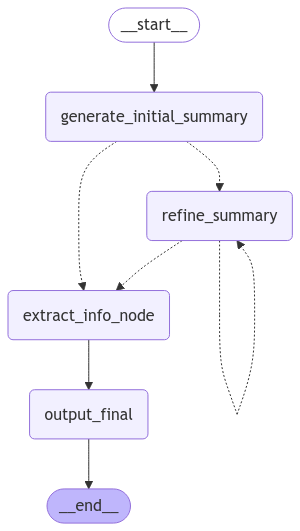

In [17]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

GENERATE PROFILE

In [18]:
all_profile = []
all_mental_bool = []
all_cured_bool = []
all_motivation_profile = []

for i in range(len(df_user)):
    documents = df_user["split_docs"][i]  
    state = await app.ainvoke({"contents": [doc.page_content for doc in documents], "extra_args": {"llm": llm}})
    profile_description_mental_health = state["output_dict"]["bad_mental_health_profile"]
    bool_mental_health = state["output_dict"]["is_badmental_health"]
    bool_mental_cured = state["output_dict"]["Is_mentally_cured"]
    motivation_profile = state["output_dict"]["motivation"]
    all_profile.append(profile_description_mental_health)
    all_mental_bool.append(bool_mental_health)
    all_cured_bool.append(bool_mental_cured)
    all_motivation_profile.append(motivation_profile)

In [19]:
df_user["profile_mental_health"] = all_profile
df_user["bool_mental_health"] = all_mental_bool
df_user["bool_mental_cured"] = all_cured_bool
df_user["motivation_profile"] = all_motivation_profile

In [20]:
df_user

,user_id,Nom,Prénom,Post,Date de publication,split_docs,profile_mental_health,bool_mental_health,bool_mental_cured,motivation_profile
0,user_1,Martin,Dupont,Today feels harder than usual; I woke up feeli...,2024-09-25 12:36:44,[page_content='Today feels harder than usual; ...,The individual is grappling with ongoing anxie...,True,False,Sharing their personal story and potentially d...
1,user_2,Lucie,Mercier,I recently started reading about mindfulness a...,2024-07-05 06:41:18,[page_content='I recently started reading abou...,Positive experience with improved anxiety mana...,True,False,Sharing these insights in the hope of helping ...
2,user_3,Thomas,Léger,This week has been particularly tough. I've be...,2024-09-26 23:57:30,[page_content='This week has been particularly...,The author is experiencing a difficult week ma...,True,False,
3,user_4,Sophie,Bernard,"I found this online support group last month, ...",2024-11-06 20:42:47,[page_content='I found this online support gro...,,False,True,The narrator found an online support group a m...
4,user_5,Rémi,Fontaine,Has anyone tried meditation? I started about t...,2024-09-01 00:03:08,[page_content='Has anyone tried meditation? I ...,The author began meditating three months ago a...,True,True,They now enjoy this daily quiet activity and r...
5,user_6,Émilie,Rousseau,"Lately, getting out of bed has been the hardes...",2024-06-03 02:38:12,"[page_content='Lately, getting out of bed has ...",The individual is battling persistent low mood...,True,False,They are actively seeking strategies and are o...
6,user_7,Paul,Moreau,Today was a surprisingly good day. After weeks...,2024-01-26 20:41:29,[page_content='Today was a surprisingly good d...,"The individual experienced a rare, positive, a...",True,False,This day was so significant that they not only...
7,user_8,Nadia,Petit,It's been a challenging week. There are days w...,2024-11-05 10:37:10,[page_content='It's been a challenging week. T...,The week has been challenging with days seemin...,True,False,It's crucial to remember that recovery is not ...
8,user_9,Julien,Fournier,Writing my thoughts here has been incredibly t...,2024-06-17 19:43:06,[page_content='Writing my thoughts here has be...,,False,True,Expressing my thoughts and receiving supportiv...
9,user_10,Marie-Claire,Dubois,I came across an article about the benefits of...,2024-10-31 10:04:58,[page_content='I came across an article about ...,,False,False,The significance of seeking professional help ...


## CONTENT

In [21]:
docs_content = []
for i in range(len(df_content)):
    
    post = df_content["Post"][i]
    content_id = df_content["content_id"][i]
    user_id = df_content["user_id"][i]
    document = Document(page_content= post, metadata= {"content_id": content_id, "user_id": user_id})
    docs_content.append(document)

In [22]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap = 20,
    length_function = len
)

split_docs = splitter.split_documents(docs_content)
split_docs

[Document(metadata={'content_id': 'content_1', 'user_id': 3}, page_content="Feeling overwhelmed by everything lately, I decided to start journaling. It's helped me process my"),
 Document(metadata={'content_id': 'content_1', 'user_id': 3}, page_content='me process my emotions better and I feel less stressed. Sharing this in case someone else finds it'),
 Document(metadata={'content_id': 'content_1', 'user_id': 3}, page_content='else finds it useful.'),
 Document(metadata={'content_id': 'content_2', 'user_id': 18}, page_content="I've been dealing with anxiety for years. Last month, I started practicing yoga, and it's made a"),
 Document(metadata={'content_id': 'content_2', 'user_id': 18}, page_content="and it's made a significant difference. It's not a cure, but it helps me manage my day better."),
 Document(metadata={'content_id': 'content_3', 'user_id': 5}, page_content='Sometimes, all you need is to talk. I had a conversation with a stranger on a park bench yesterday'),
 Document(met

In [23]:
from collections import defaultdict

grouped_chunks = defaultdict(list)
for chunk in split_docs:
    content_id = chunk.metadata["content_id"]
    grouped_chunks[content_id].append(chunk)

user_list_doc_content = list(grouped_chunks.values())

In [24]:
user_list_doc_content

[[Document(metadata={'content_id': 'content_1', 'user_id': 3}, page_content="Feeling overwhelmed by everything lately, I decided to start journaling. It's helped me process my"),
  Document(metadata={'content_id': 'content_1', 'user_id': 3}, page_content='me process my emotions better and I feel less stressed. Sharing this in case someone else finds it'),
  Document(metadata={'content_id': 'content_1', 'user_id': 3}, page_content='else finds it useful.')],
 [Document(metadata={'content_id': 'content_2', 'user_id': 18}, page_content="I've been dealing with anxiety for years. Last month, I started practicing yoga, and it's made a"),
  Document(metadata={'content_id': 'content_2', 'user_id': 18}, page_content="and it's made a significant difference. It's not a cure, but it helps me manage my day better.")],
 [Document(metadata={'content_id': 'content_3', 'user_id': 5}, page_content='Sometimes, all you need is to talk. I had a conversation with a stranger on a park bench yesterday'),
  Doc

In [25]:
df_content["split_docs"] = user_list_doc_content

In [26]:
from graph_user_recommand_content import create_app

app_content = create_app()

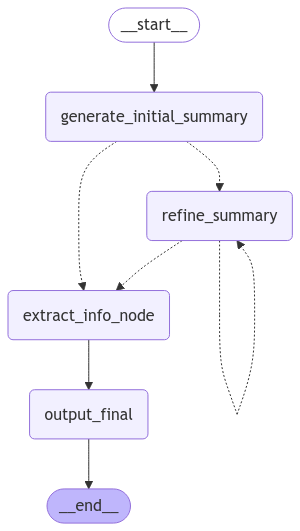

In [27]:
from IPython.display import Image

Image(app_content.get_graph().draw_mermaid_png())

In [28]:
all_profile = []
all_mental_bool = []
all_cured_bool = []
all_is_motivation_profile = []
all_motivation_profile = []

for i in range(len(df_content)):
    documents = df_content["split_docs"][i]  
    state = await app_content.ainvoke({"contents": [doc.page_content for doc in documents], "extra_args": {"llm": llm}})
    profile_description_mental_health = state["output_dict"]["bad_mental_health_profile"]
    bool_mental_health = state["output_dict"]["is_badmental_health"]
    bool_mental_cured = state["output_dict"]["Is_mentally_cured"]
    is_motivation_profile = state["output_dict"]["is_motivation"]
    motivation_profile = state["output_dict"]["motivations_info"]
    all_profile.append(profile_description_mental_health)
    all_mental_bool.append(bool_mental_health)
    all_cured_bool.append(bool_mental_cured)
    all_is_motivation_profile.append(is_motivation_profile)
    all_motivation_profile.append(motivation_profile)

In [29]:
df_content["profile_mental_health"] = all_profile
df_content["bool_mental_health"] = all_mental_bool
df_content["bool_mental_cured"] = all_cured_bool
df_content["is_motivation_profile"] = all_is_motivation_profile
df_content["motivations_info"] = all_motivation_profile

In [30]:
df_content

,content_id,user_id,Nom,Prénom,Post,Date de publication,split_docs,profile_mental_health,bool_mental_health,bool_mental_cured,is_motivation_profile,motivations_info
0,content_1,3,Isabelle,Toussaint,"Feeling overwhelmed by everything lately, I de...",2024-10-04 13:30:28,[page_content='Feeling overwhelmed by everythi...,,False,True,True,The activity serves as a therapeutic tool that...
1,content_2,18,Antoine,Richard,I've been dealing with anxiety for years. Last...,2024-04-21 10:35:19,[page_content='I've been dealing with anxiety ...,The management of my anxiety has significantly...,True,False,True,The management of my anxiety
2,content_3,5,Béatrice,Delorme,"Sometimes, all you need is to talk. I had a co...",2024-09-02 22:41:27,"[page_content='Sometimes, all you need is to t...",,False,True,True,The author emphasizes the importance of commun...
3,content_4,12,Damien,Girard,I want to remind everyone that it's okay to se...,2024-05-01 20:07:30,[page_content='I want to remind everyone that ...,,False,True,True,The speaker is advocating for mental health su...
4,content_5,26,Éloise,Lapointe,"To anyone struggling today, remember that prog...",2024-09-03 12:54:45,"[page_content='To anyone struggling today, rem...",,False,True,True,The message provides reassurance to those unde...
5,content_6,14,Fabien,Bernard,Sharing a small victory: I finally felt like m...,2024-03-26 16:54:12,[page_content='Sharing a small victory: I fina...,,False,True,True,Recognizing and celebrating small personal vic...
6,content_7,19,Giselle,Marchand,It's important to set boundaries for your ment...,2024-02-27 15:45:05,[page_content='It's important to set boundarie...,,False,True,True,Setting boundaries is crucial for maintaining ...
7,content_8,27,Hugo,Lefevre,Connecting with nature has been my therapy. Wa...,2024-06-10 11:56:07,[page_content='Connecting with nature has been...,,False,True,True,The author finds therapeutic benefits from con...
8,content_9,2,Irina,Petrov,"If you're feeling stuck, change something smal...",2024-08-02 15:08:27,"[page_content='If you're feeling stuck, change...",,False,False,True,A small change can help you feel more in contr...
9,content_10,26,Jérôme,Moreau,Gratitude has changed my outlook on life. Each...,2024-02-22 07:56:13,[page_content='Gratitude has changed my outloo...,,False,True,True,Practicing gratitude has positively impacted m...


## VECTORSTORE

In [31]:
embeddings = OpenAIEmbeddings()

In [47]:
vector_store_mental_health = Chroma(
    collection_name="mental_health",
    embedding_function=embeddings,
    persist_directory="./vectorstore_mental_health", 
)

In [54]:
vector_store_motivation = Chroma(
    collection_name="motivation-tips",
    embedding_function=embeddings,
    persist_directory="./vectorstore_motivation_tips", 
)

In [36]:
df_content_mental_health_cured = df_content[(df_content["bool_mental_health"] == "True") & (df_content["bool_mental_cured"] == "True")]
df_content_motivation = df_content[df_content["is_motivation_profile"] == "True"]

In [43]:
df_content_motivation.head()

,content_id,user_id,Nom,Prénom,Post,Date de publication,split_docs,profile_mental_health,bool_mental_health,bool_mental_cured,is_motivation_profile,motivations_info
0,content_1,3,Isabelle,Toussaint,"Feeling overwhelmed by everything lately, I de...",2024-10-04 13:30:28,[page_content='Feeling overwhelmed by everythi...,,False,True,True,The activity serves as a therapeutic tool that...
1,content_2,18,Antoine,Richard,I've been dealing with anxiety for years. Last...,2024-04-21 10:35:19,[page_content='I've been dealing with anxiety ...,The management of my anxiety has significantly...,True,False,True,The management of my anxiety
2,content_3,5,Béatrice,Delorme,"Sometimes, all you need is to talk. I had a co...",2024-09-02 22:41:27,"[page_content='Sometimes, all you need is to t...",,False,True,True,The author emphasizes the importance of commun...
3,content_4,12,Damien,Girard,I want to remind everyone that it's okay to se...,2024-05-01 20:07:30,[page_content='I want to remind everyone that ...,,False,True,True,The speaker is advocating for mental health su...
4,content_5,26,Éloise,Lapointe,"To anyone struggling today, remember that prog...",2024-09-03 12:54:45,"[page_content='To anyone struggling today, rem...",,False,True,True,The message provides reassurance to those unde...


In [73]:
def clean_metadata(metadata):
    """
    Convertit toutes les valeurs des métadonnées en types compatibles avec Chroma (str, int, float, bool).
    """
    cleaned_metadata = {}
    for key, value in metadata.items():
        if isinstance(value, (str, int, float, bool)):
            cleaned_metadata[key] = value
        elif hasattr(value, "isoformat"):  # Dates (Timestamp ou datetime)
            cleaned_metadata[key] = value.isoformat()
        else:
            cleaned_metadata[key] = str(value)  # Convertir tout autre type en chaîne
    return cleaned_metadata

In [74]:
docs_mental_health_cured = []

for i in range(len(df_content_mental_health_cured)):
    post_mental_health = df_content_mental_health_cured["profile_mental_health"][i]
    content_id = df_content_mental_health_cured["content_id"][i]
    user_id = df_content_mental_health_cured["user_id"][i]
    date = df_content_mental_health_cured["Date de publication"][i]
    
    # Métadonnées brutes
    raw_metadata = {"content_id": content_id, "user_id": user_id, "date": date}

    # Nettoyer les métadonnées
    clean_meta = clean_metadata(raw_metadata)

    # Créer un Document
    document = Document(page_content=post_mental_health, metadata=clean_meta)
    docs_mental_health_cured.append(document)

In [75]:
docs_mental_health_cured

[]

In [76]:
docs_motivation_tips = []

for i in range(len(df_content_motivation)):
    post_motivation = df_content_motivation["motivations_info"][i]
    content_id = df_content_motivation["content_id"][i]
    user_id = df_content_motivation["user_id"][i]
    date = df_content_motivation["Date de publication"][i]
    
    # Métadonnées brutes
    raw_metadata = {"content_id": content_id, "user_id": user_id, "date": date}

    # Nettoyer les métadonnées
    clean_meta = clean_metadata(raw_metadata)

    # Créer un Document
    document = Document(page_content=post_motivation, metadata=clean_meta)
    docs_motivation_tips.append(document)

In [77]:
docs_motivation_tips

[Document(metadata={'content_id': 'content_1', 'user_id': '3', 'date': '2024-10-04T13:30:28'}, page_content='The activity serves as a therapeutic tool that helps in dealing with emotions and stress management through self-reflection, expression, and sharing. Not only does this process benefit the individual, but it can also be useful to others who may relate to or find comfort in the shared experiences.'),
 Document(metadata={'content_id': 'content_2', 'user_id': '18', 'date': '2024-04-21T10:35:19'}, page_content='The management of my anxiety'),
 Document(metadata={'content_id': 'content_3', 'user_id': '5', 'date': '2024-09-02T22:41:27'}, page_content='The author emphasizes the importance of communication and human connection'),
 Document(metadata={'content_id': 'content_4', 'user_id': '12', 'date': '2024-05-01T20:07:30'}, page_content="The speaker is advocating for mental health support, stating that seeking therapy was the best decision they've made for their mental health and encour

In [62]:
if len(docs_mental_health_cured) > 0:
    uuids = [str(uuid4()) for _ in range(len(docs_mental_health_cured))]
    vector_store_mental_health.add_documents(documents=[], ids=uuids)

In [78]:
if len(docs_motivation_tips) > 0:
    uuids = [str(uuid4()) for _ in range(len(docs_motivation_tips))]
    vector_store_motivation.add_documents(documents=docs_motivation_tips, ids=uuids)

CONTENT RECOMMANDATION

In [ ]:
for i in range(len(df_user)):
    if df_user["bool_mental_health"] == "True":
        query = df_user["profile_mental_health"]
        
        

[]

In [27]:
similarity_profile_docs = []

for i in range(len(df)):
    current_user_id = i+1
    query = df["profile_mental_health"][i]
    filter_query = {
        "$and": [
            {"bool_mental_cured": {"$eq": "True"}},
            {"user_id": {"$ne": current_user_id}}
        ]
    }
    docs = vectorstore.similarity_search(query = query,
                                filter = filter_query)
    similarity_profile_docs.append(docs)

df["similar_profile"] = similarity_profile_docs

In [30]:
df

,Nom Prénom,Âge,Post,split_docs,profile_mental_health,bool_mental_health,bool_mental_cured,similar_profile
0,Martin Dupont,34,"Je m'appelle Martin Dupont, 34 ans. Après avoi...","[page_content='Je m'appelle Martin Dupont, 34 ...",After a challenging period of unemployment and...,True,True,"[page_content='Lucie Mercier, 29, shares her s..."
1,Lucie Mercier,29,"Je suis Lucie Mercier, 29 ans. Durant mes étud...","[page_content='Je suis Lucie Mercier, 29 ans. ...","Lucie Mercier, 29, shares her struggle with an...",True,True,"[page_content='Rémi Fontaine, 27, who previous..."
2,Thomas Léger,42,"Thomas Léger ici, 42 ans. La séparation avec m...","[page_content='Thomas Léger ici, 42 ans. La sé...","Thomas Léger, 42 years old, states that his se...",True,False,[page_content='After a challenging period of u...
3,Sophie Bernard,36,"Je m'appelle Sophie Bernard, 36 ans, et j'ai c...","[page_content='Je m'appelle Sophie Bernard, 36...","Sophie Bernard, a 36-year-old mother, had a ba...",True,True,"[page_content='Lucie Mercier, 29, shares her s..."
4,Rémi Fontaine,27,"Je suis Rémi Fontaine, 27 ans. Mes troubles an...","[page_content='Je suis Rémi Fontaine, 27 ans. ...","Rémi Fontaine, 27, who previously suffered fro...",True,True,"[page_content='Lucie Mercier, 29, shares her s..."
5,Émilie Rousseau,31,"Émilie Rousseau, 31 ans. J'ai affronté une dép...","[page_content='Émilie Rousseau, 31 ans. J'ai a...",Émilie Rousseau had work-induced depression,True,True,"[page_content='Lucie Mercier, 29, shares her s..."
6,Paul Moreau,39,"Paul Moreau, 39 ans. J'ai subi un stress inten...","[page_content='Paul Moreau, 39 ans. J'ai subi ...","Paul Moreau, a 39-year-old, has experienced in...",True,False,[page_content='After a challenging period of u...
7,Nadia Petit,45,"Nadia Petit, 45 ans. Je vis avec une dépressio...","[page_content='Nadia Petit, 45 ans. Je vis ave...","Nadia Petit, 45, lives with chronic depression...",True,False,"[page_content='Lucie Mercier, 29, shares her s..."
8,Julien Fournier,22,"Julien Fournier, 22 ans. J'ai souffert de dépr...","[page_content='Julien Fournier, 22 ans. J'ai s...",Julien Fournier battled depression and feeling...,True,True,"[page_content='Rémi Fontaine, 27, who previous..."
9,Marie-Claire Dubois,38,"Marie-Claire Dubois, 38 ans. Licenciée il y a ...","[page_content='Marie-Claire Dubois, 38 ans. Li...","Marie-Claire Dubois, 38, who was laid off a ye...",True,False,[page_content='Émilie Rousseau had work-induce...


PRINT SIMILAR PROFILE FOR EACH USERS

In [41]:
for i in range(len(df)):

    print("user_id for the user:", i+1)
    print("user's username:", df["Nom Prénom"][i])
    print("\n")
    print("Here is relevant profiles that were also in bad mental health but have overcome all their difficulties, contact them if you want some advice ^^:")
    for doc in df["similar_profile"][i]:
        print(doc.metadata["username"])
    print("\n")
    print("-------------------------------------------------------------------------------------------------------------------")

user_id for the user: 1
user's username: Martin Dupont


Here is relevant profiles that were also in bad mental health but have overcome all their difficulties, contact them if you want some advice ^^:
Lucie Mercier
Rémi Fontaine
Julien Fournier
Émilie Rousseau


-------------------------------------------------------------------------------------------------------------------
user_id for the user: 2
user's username: Lucie Mercier


Here is relevant profiles that were also in bad mental health but have overcome all their difficulties, contact them if you want some advice ^^:
Rémi Fontaine
Émilie Rousseau
Sophie Bernard
Julien Fournier


-------------------------------------------------------------------------------------------------------------------
user_id for the user: 3
user's username: Thomas Léger


Here is relevant profiles that were also in bad mental health but have overcome all their difficulties, contact them if you want some advice ^^:
Martin Dupont
Lucie Mercier
Émilie Rou